# Transform 2021 NLP demo by Anne Estoppey
### Friendly workflows with Natural Language Processing: well report summaries.

## Introduction
In this Jupyter Notebook, we will explore different aspects of NLP (Natural Language Processing). We will use well report summaries which are published by the NPD (Norwegian Petroleum Directorate), by requesting via an API. We will go through the different stages of text cleaning and formatting before moving on to NLP processing: tockenization, lemmatization and finally topic modeling.<br>

Level: intermediate. We expect participants to be familiar with mid level programming in python. Please see the requirements file and readme on the github repo.<br>

The well report summaries are available here: https://hotell.difi.no/?dataset=npd/wellbore/with-history (well report summaries).<br> 

The following link should go to all data available from Norwegian Oil Directorate, in public domain: https://data.norge.no/datasets/4304aea1-53b1-47ed-beae-52bf4d3642f3 (link might get broken over time).<br>

#### Requirements - specific libraries for NLP
This notebook was run with Python version 3.7.4, from Jupyter lab. <br>

<b>spaCy: </b>free, open-source library for advanced Natural Language Processing (NLP) in Python.<br>
In this notebook we are using <b>spaCy version 3.0.5.</b><br>
<b>To install spaCy language model: (after you have installed the library) </b><br>
> pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.0.0/en_core_web_sm-3.0.0.tar.gz <br>

Github repo <a href="https://github.com/explosion/spacy-models"> here.</a><br>
More about spaCy <a href="https://spacy.io/usage/spacy-101"> here.</a><br>
More about the language model newest version <a href="https://spacy.io/usage/v3"> here.</a><br>
    
<b>gensim: </b> Gensim is a Python library for topic modelling, document indexing and similarity retrieval with large corpora (where 'corpus' or 'corpora' is collection of texts).<br>
More about gensim <a href="https://pypi.org/project/gensim/"> here.</a><br>
    
<b>pyLDAvis: </b>is designed to help users interpret the topics in a topic model that has been fit to a collection of text data.<br>
<b>Important: </b>You will need the following version of pyLDAvis for the topics visualisation: <b>pyLDAvis 2.1.2</b>.
<br>You'll need to install pyLDAvis 2.1.2 from PIP!<br>
More about pyLDAvis and topic modelling <a href="https://neptune.ai/blog/pyldavis-topic-modelling-exploration-tool-that-every-nlp-data-scientist-should-know"> here.</a><br>
#### How to fix blank maps and graph in jupyter lab!!
Check out link <a href="https://stackoverflow.com/questions/54936125/plotly-gives-an-empty-field-as-output-in-jupyter-lab"> here.</a><br>
To check if your jupyter lab plotly extension is up and running: > jupyter labextension list

#### References
Michael Dowling's repo: https://github.com/MichaelMDowling/TopicModel<br>
About evaluation of topic models, LDA: <a href="https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0"> this article in towardsdatascience. </a><br>
Research article about LDAvis: <a href="https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf"> here.</a><br>
<b>Books</b><br>
'Practical Natural Language Processing', Sowmya Vajjala, Bodhisattwa Majumder, Anuj Gupta, and Harshit Surana, O'Reilly, 2020<br>
'Python Natural Language Processing Cookbook', Antić Zhenya, Packt Publishing, 2021

---

In [1]:
import pandas as pd
import numpy as np
from pprint import pprint
import re, os, operator
import collections 
import matplotlib.pyplot as plt
import requests
import json
import warnings

import geopandas as gpd

import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

import spacy

import gensim
from gensim.corpora import Dictionary
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
# from gensim.models.wrappers import LdaMallet

import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px

from wordcloud import WordCloud

In [2]:
warnings.filterwarnings('ignore')

In [3]:
#### REMOVE THIS CELL BEFORE DEMO, THIS IS FOR TESTING! ####

# set max number of rows for pandas
# pd.set_option('display.max_rows', 2000)

#### API connection - check for status
Make a general get request, print out status code. 
Status code = 200 means API connection is up and running.

In [4]:
requests.get('https://data.norge.no/api/dcat/870917732/data.json')

<Response [200]>

#### Get request - Well summaries
The datasets are paginated. The first page will tell us how many pages there are in total, and how many rows for the whole dataset.

In [5]:
wells_summary = requests.get('https://hotell.difi.no/api/json/npd/wellbore/with-history?page=1')
json_wells_summary = wells_summary.json()
print(f'number of pages: {json_wells_summary["pages"]}')
print(f'number of rows:  {json_wells_summary["posts"]}')

number of pages: 19
number of rows:  1825


#### Let's go through all the pages and append all the rows in JSON dictionary
Create a pandas dataframe from the json file

In [6]:
def get_all_data(url_dataset, df_out_name):
    '''getting number of pages,
    looping through all pages,
    append in JSON dictionary,
    create dataframe
    '''
    wells_summary = requests.get(url_dataset)
    json_count_page = wells_summary.json()
    
    page = json_count_page['pages']
    all_data_list = []
    for i in range(0, page):
        url = url_dataset + f'?page={i+1}'
        dataset_all = requests.get(url)
        dataset_all_json = dataset_all.json()
        number_of_entries = len(dataset_all_json['entries'])

        for entry in range(0, number_of_entries):
            all_data_list.append(dataset_all_json['entries'][entry])

    df_out_name = pd.DataFrame(all_data_list)
    return df_out_name

#### Getting all our well summaries into a dataframe

In [7]:
url_dataset ='https://hotell.difi.no/api/json/npd/wellbore/with-history'
df_out_name = 'df_all_summaries'
# json_count_page = json_wells_summary  # total number of pages (pagination)
df_all_summaries = get_all_data(url_dataset, df_out_name)

In [8]:
df_all_summaries.shape

(1825, 5)

In [9]:
df_all_summaries.head()

wlbHistoryDateUpdated   wlbName wlbNPDID_wellbore  \
0   7/6/2016 12:00:00 AM     1/2-1              1382   
1  4/11/2017 12:00:00 AM     1/2-2              5192   
2  5/19/2016 12:00:00 AM     1/3-1               154   
3  4/11/2017 12:00:00 AM    1/3-10              5614   
4  4/11/2017 12:00:00 AM  1/3-10 A              5779   

                                          wlbHistory datesyncNPD  
0  <p><b>General</b></p>\n\n<p>Well 1/2-1 is loca...  04.04.2021  
1  <p>The 1/2-2 well was drilled to evaluate the ...  04.04.2021  
2  <p class=MsoBodyText><b><span lang=EN-GB>Gener...  04.04.2021  
3  <p class=MsoBodyText><b><span lang=EN-GB>Gener...  04.04.2021  
4  <p class=MsoBodyText><b><span lang=EN-GB>Gener...  04.04.2021

In [10]:
# check for duplicate wells!
def check_for_duplicates(df, column_name):
    boolean = df[column_name].duplicated().any()
    if boolean == True:
        pd.concat(g for _, g in df.groupby(column_name) if len(g) > 1)
    else:
        print("No duplicates!")
    return

In [11]:
check_for_duplicates(df_all_summaries, 'wlbName')

No duplicates!


#### Display a complete summary - we will need to clean all this html code!

In [12]:
# Display well summary (wlbHistory) 
df_all_summaries.iloc[1500]['wlbHistory']

'<b>\nGeneral\n</b>\n<p>\nWell 6508/1-1 S was drilled in between the Norne Field and the Nordland Ridge. Well 6508/1- 1 A was sidetracked from below the 13 3/8" casing shoe in 6508/1-1 S. Water based mud was used in both well tracks.\nThe main purpose of 6508/1-1 S was to test for the presence of hydrocarbons in the Middle Jurassic, Fangst Group. The secondary purposes were to test for the presence of hydrocarbons in the sandstone immediately above the Tertiary-Cretaceous boundary (Paleocene-Campanian) as well as for possible sandstones in the Cretaceous succession, in the Upper Jurassic Melke Formation, and in lower Jurassic Båt Group.\nThe main purpose of 6508/1-1 A was to test for the presence of hydrocarbons in the Upper Jurassic Rogn Formation. The secondary objective was to test for the presence of sandstone and hydrocarbons both above and below the Tertiary-Cretaceous boundary (Paleocene-Campanian), possible sandstones in the Cretaceous succession, in the Upper Jurassic Melke Fo

#### Getting geolocation information for all wells - we will append this information to our well summary dataframe

In [13]:
wells_with_coordinates = requests.get('https://hotell.difi.no/api/json/npd/wellbore/with-coordinates?page=1')
json_wells_with_coordinates = wells_with_coordinates.json()
print(f'number of pages: {json_wells_with_coordinates["pages"]}')
print(f'number of rows:  {json_wells_with_coordinates["posts"]}')

number of pages: 85
number of rows:  8485


In [14]:
url_dataset = 'https://hotell.difi.no/api/json/npd/wellbore/with-coordinates'
df_out_name = 'df_all_with_coord'
# json_count_page = json_wells_with_coordinates  # total pagination number
df_all_with_coord = get_all_data(url_dataset, df_out_name)

In [15]:
df_all_with_coord.shape

(8485, 26)

In [16]:
df_all_with_coord.head()

wlbUtmZone  wlbWellType wlbEwDeg wlbEwCode wlbEntryDate wlbNsSec wlbEwMin  \
0         31  EXPLORATION        2         E   20.03.1989    15.07       28   
1         31  EXPLORATION        2         E   14.12.2005       32       29   
2         31        OTHER        2         E   09.05.2009    55.58       27   
3         31        OTHER        2         E   12.05.2009    56.95       27   
4         31        OTHER        2         E   12.05.2009    54.99       27   

  wlbEwSec wlbNsDecDeg wlbProductionLicence  ...   wlbEwUtm wlbNsMin  \
0     35.7   56.887519                  143  ...  468106.29       53   
1    47.66   56.992222               143 CS  ...  469410.10       59   
2     5.01   56.948772                  143  ...  466625.99       56   
3     7.69   56.949153                  143  ...  466671.62       56   
4     8.52   56.948608                  143  ...  466685.16       56   

  wlbWellboreName wlbContent            wlbDrillingOperator wlbEwDesDeg  \
0           1/2-1        OIL    Phillips Petroleum Norsk AS    2.476583   
1           1/2-2  OIL SHOWS     Paladin Resources Norge AS    2.496572   
2         1/2-U-1             ConocoPhillips Skandinavia AS    2.451392   
3         1/2-U-2             ConocoPhillips Skandinavia AS    2.452136   
4         1/2-U-3             ConocoPhillips Skandinavia AS    2.452367   

     wlbNsUtm wlbGeodeticDatum datesyncNPD wlbMainArea  
0  6305128.26             ED50  04.04.2021   NORTH SEA  
1  6316774.33             ED50  04.04.2021   NORTH SEA  
2  6311958.73             ED50  04.04.2021   NORTH SEA  
3  6312000.73             ED50  04.04.2021   NORTH SEA  
4  6311940.01             ED50  04.04.2021   NORTH SEA  

[5 rows x 26 columns]

In [17]:
# check for duplicate wells!
check_for_duplicates(df_all_with_coord, 'wlbWellboreName')

No duplicates!


#### Having a quick check on a map with our dataframe with coordinates

In [18]:
df_all_with_coord['wlbNsDecDeg'] = df_all_with_coord['wlbNsDecDeg'].astype(float).round(3)
df_all_with_coord['wlbEwDesDeg'] = df_all_with_coord['wlbEwDesDeg'].astype(float).round(3)

In [19]:
df_all_with_coord.dtypes

wlbUtmZone               object
wlbWellType              object
wlbEwDeg                 object
wlbEwCode                object
wlbEntryDate             object
wlbNsSec                 object
wlbEwMin                 object
wlbEwSec                 object
wlbNsDecDeg             float64
wlbProductionLicence     object
wlbNsDeg                 object
wlbNpdidWellbore         object
wlbPurposePlanned        object
wlbField                 object
wlbNsCode                object
wlbCompletionDate        object
wlbEwUtm                 object
wlbNsMin                 object
wlbWellboreName          object
wlbContent               object
wlbDrillingOperator      object
wlbEwDesDeg             float64
wlbNsUtm                 object
wlbGeodeticDatum         object
datesyncNPD              object
wlbMainArea              object
dtype: object

#### Drawing scatter map function

In [20]:
def drawScatterMap(dataframe, colorColumn, title):
    fig = px.scatter_mapbox(dataframe, 
                            lat="wlbNsDecDeg", lon="wlbEwDesDeg", 
                            color=colorColumn, 
                            width=1000, height=1000, 
                            # color_discrete_sequence=["red", "green", "blue", "goldenrod", "magenta"],
                            color_discrete_sequence=px.colors.qualitative.D3,
                            hover_name='wlbWellboreName',
                            hover_data={'wlbMainArea' : False,
                                        'wlbNsDecDeg' : False,
                                        'wlbEwDesDeg' : False,
                                        'wlbContent'  : True,
                                        'wlbWellType' : True
                                       },
                            center={'lat':71, 'lon':20},
                            zoom=3, 
                            # mapbox_style="stamen-watercolor",
                            mapbox_style="carto-positron",
                            title=title
                            )


    return fig.show()

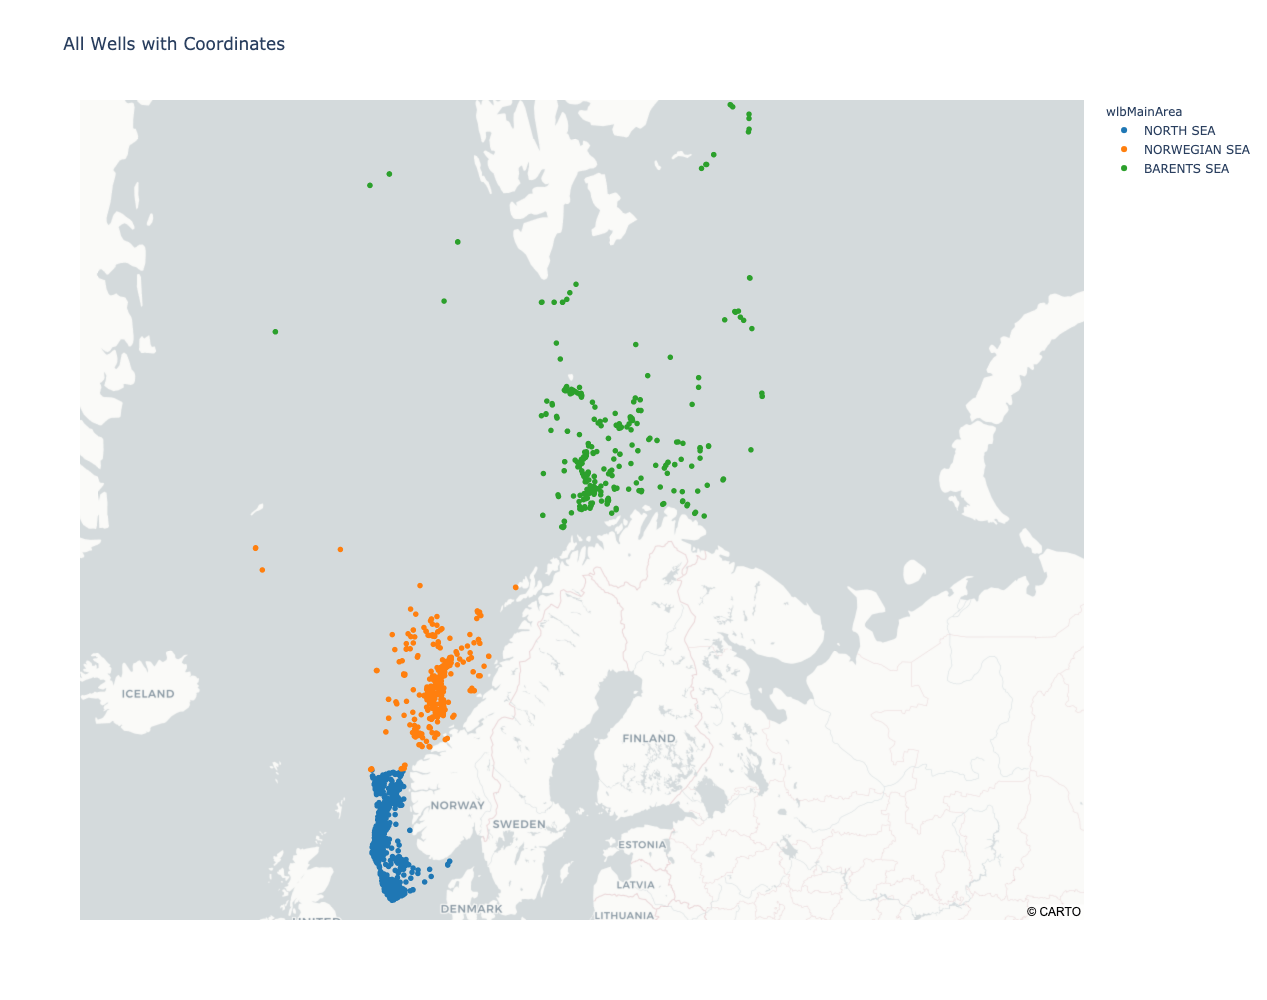

In [21]:
drawScatterMap(df_all_with_coord, 'wlbMainArea', 'All Wells with Coordinates')

In [22]:
df_all_with_coord.wlbMainArea.unique()

array(['NORTH SEA', 'NORWEGIAN SEA', 'BARENTS SEA'], dtype=object)

#### Merging df_all_with_coord together with df_all_summaries to get coordinates in the summary df

In [23]:
df_summaries_coord = pd.merge(df_all_summaries, 
                              df_all_with_coord[['wlbEwDesDeg', 'wlbNsDecDeg', 'wlbEwUtm', 'wlbNsUtm',
                                                 'wlbWellboreName', 'wlbContent', 'wlbMainArea', 'wlbDrillingOperator', 'wlbWellType']], how='left',
                              left_on='wlbName', right_on='wlbWellboreName')

In [24]:
df_summaries_coord.shape

(1825, 14)

In [25]:
df_summaries_coord.head()

wlbHistoryDateUpdated   wlbName wlbNPDID_wellbore  \
0   7/6/2016 12:00:00 AM     1/2-1              1382   
1  4/11/2017 12:00:00 AM     1/2-2              5192   
2  5/19/2016 12:00:00 AM     1/3-1               154   
3  4/11/2017 12:00:00 AM    1/3-10              5614   
4  4/11/2017 12:00:00 AM  1/3-10 A              5779   

                                          wlbHistory datesyncNPD  wlbEwDesDeg  \
0  <p><b>General</b></p>\n\n<p>Well 1/2-1 is loca...  04.04.2021        2.477   
1  <p>The 1/2-2 well was drilled to evaluate the ...  04.04.2021        2.497   
2  <p class=MsoBodyText><b><span lang=EN-GB>Gener...  04.04.2021        2.851   
3  <p class=MsoBodyText><b><span lang=EN-GB>Gener...  04.04.2021        2.706   
4  <p class=MsoBodyText><b><span lang=EN-GB>Gener...  04.04.2021        2.706   

   wlbNsDecDeg   wlbEwUtm    wlbNsUtm wlbWellboreName wlbContent wlbMainArea  \
0       56.888  468106.29  6305128.26           1/2-1        OIL   NORTH SEA   
1       56.992  469410.10  6316774.33           1/2-2  OIL SHOWS   NORTH SEA   
2       56.856  490936.87  6301488.86           1/3-1        GAS   NORTH SEA   
3       56.928  482089.29  6309521.94          1/3-10    OIL/GAS   NORTH SEA   
4       56.928  482089.29  6309521.94        1/3-10 A    OIL/GAS   NORTH SEA   

           wlbDrillingOperator  wlbWellType  
0  Phillips Petroleum Norsk AS  EXPLORATION  
1   Paladin Resources Norge AS  EXPLORATION  
2             A/S Norske Shell  EXPLORATION  
3            DONG E&P Norge AS  EXPLORATION  
4            DONG E&P Norge AS  EXPLORATION

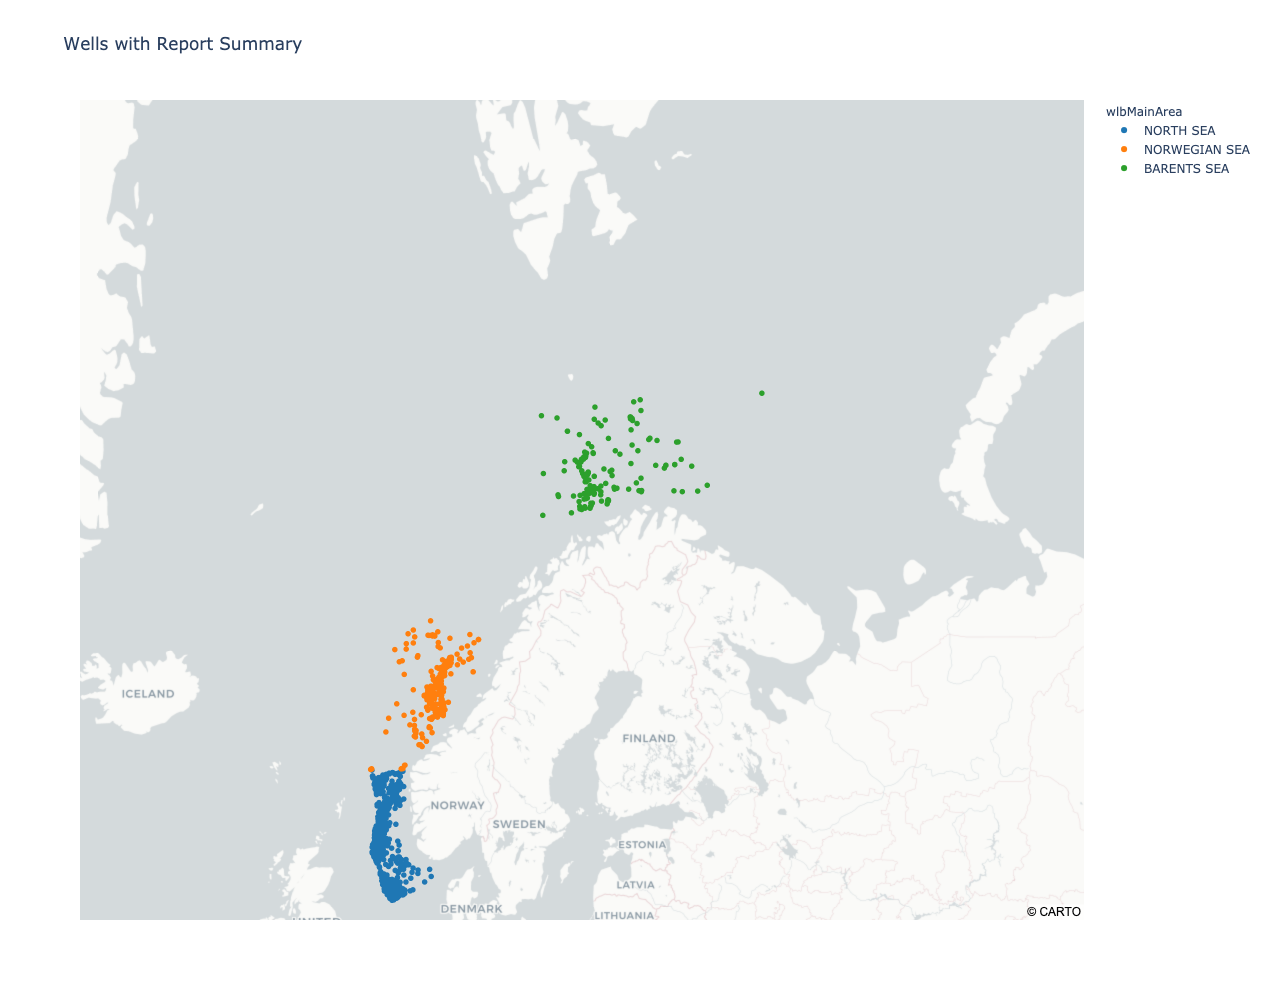

In [26]:
drawScatterMap(df_summaries_coord, 'wlbMainArea', 'Wells with Report Summary')

---

#### Starting cleaning of well summaries in the dataframe

In [27]:
# creating a copy of dataframe
df_summaries_coord_clean = df_summaries_coord.copy()
df_summaries_coord_clean.shape

(1825, 14)

#### We start with some basic text cleaning (removing html and new line tags, and replacing bad quotation tags).
We create a new attribute 'wlbHistory_clean' with the resulting clean texts.

In [28]:
def cleanhtml():
    # remove html tags
    cleanr = re.compile('<.*?>')
    
    rows = df_summaries_coord_clean['wlbHistory']
    listcleantext = []
    for r in rows:
        cleantext = re.sub(cleanr, '', r)
        
        # replace new line \n with empty space
        cleantext = cleantext.replace('\n', ' ')
        
        # replace &quot; with single quote (inch)
        cleantext = cleantext.replace('&quot;', "''")
        
        listcleantext.append(cleantext)
    df_summaries_coord_clean['wlbHistory_clean'] = listcleantext
    return

In [29]:
cleanhtml()

In [30]:
df_summaries_coord_clean.shape

(1825, 15)

In [31]:
df_summaries_coord_clean.head()

wlbHistoryDateUpdated   wlbName wlbNPDID_wellbore  \
0   7/6/2016 12:00:00 AM     1/2-1              1382   
1  4/11/2017 12:00:00 AM     1/2-2              5192   
2  5/19/2016 12:00:00 AM     1/3-1               154   
3  4/11/2017 12:00:00 AM    1/3-10              5614   
4  4/11/2017 12:00:00 AM  1/3-10 A              5779   

                                          wlbHistory datesyncNPD  wlbEwDesDeg  \
0  <p><b>General</b></p>\n\n<p>Well 1/2-1 is loca...  04.04.2021        2.477   
1  <p>The 1/2-2 well was drilled to evaluate the ...  04.04.2021        2.497   
2  <p class=MsoBodyText><b><span lang=EN-GB>Gener...  04.04.2021        2.851   
3  <p class=MsoBodyText><b><span lang=EN-GB>Gener...  04.04.2021        2.706   
4  <p class=MsoBodyText><b><span lang=EN-GB>Gener...  04.04.2021        2.706   

   wlbNsDecDeg   wlbEwUtm    wlbNsUtm wlbWellboreName wlbContent wlbMainArea  \
0       56.888  468106.29  6305128.26           1/2-1        OIL   NORTH SEA   
1       56.992  469410.10  6316774.33           1/2-2  OIL SHOWS   NORTH SEA   
2       56.856  490936.87  6301488.86           1/3-1        GAS   NORTH SEA   
3       56.928  482089.29  6309521.94          1/3-10    OIL/GAS   NORTH SEA   
4       56.928  482089.29  6309521.94        1/3-10 A    OIL/GAS   NORTH SEA   

           wlbDrillingOperator  wlbWellType  \
0  Phillips Petroleum Norsk AS  EXPLORATION   
1   Paladin Resources Norge AS  EXPLORATION   
2             A/S Norske Shell  EXPLORATION   
3            DONG E&P Norge AS  EXPLORATION   
4            DONG E&P Norge AS  EXPLORATION   

                                    wlbHistory_clean  
0  General  Well 1/2-1 is located in the Central ...  
1  The 1/2-2 well was drilled to evaluate the pro...  
2  General  Well 1/3-1 was drilled on the crest o...  
3  General  Well 1/3-10 is located on the Hidra H...  
4  General  Well 1/3-10 A is located on the Hidra...

In [32]:
# rawtext_sample = df_summaries_coord_clean.iloc[2]['wlbHistory']
# rawtext_sample

In [33]:
# cleantext_sample = df_summaries_coord_clean.iloc[2]['wlbHistory_clean']
# cleantext_sample

In [34]:
# counting words in string (simple count based on white space between words)
# len(cleantext_sample.split())

---

### Pre-processing for NLP

We continue with our dataframe 'df_summaries_coord_clean'

#### We calculate the average length (number of words) for all summaries in dataframe wlbHistory_clean:

In [35]:
print('Average wlbHistory length: ' + str(df_summaries_coord_clean["wlbHistory_clean"].str.split().str.len().mean()))

Average wlbHistory length: 408.0213698630137


#### We can enter a well name, and its summary will be grabbed for cleaning and then displaying in a wordcloud.

In [36]:
wellname = input('Please enter well name: ')

Please enter well name:  1/3-3


In [37]:
try:
    wi1 = next(iter(df_summaries_coord_clean[df_summaries_coord_clean['wlbName']== wellname].index), 'no match')
    wi2 = wi1 + 1
    # print(wi1)
    # print(wi2)
except:
    print('Please enter well name in proper format. Examples: 1/3-5, 1/3-9 S, 6406/2-1')

#### We create a list of strings, where each well summary is a separate string.

In [38]:
wlbHistory_clean_to_list = df_summaries_coord_clean["wlbHistory_clean"].values.tolist()

#### Let's have a look at our well summary (wi1 and wi2 are the index values for a given well in dataframe)

In [39]:
pprint(wlbHistory_clean_to_list[wi1:wi2])

['General  Well 1/3-3 is located on the Cod Terrace in the North Sea. It was '
 'drilled to evaluate the hydrocarbon potential of both the Late Jurassic and '
 'the Triassic sandstone formations. Main target was the Late Jurassic Ula '
 'Formation found oil bearing in the Ula field, 17 km to the NW, and in the '
 'well 2/1-3. Secondary target was the Triassic sandstone found oil bearing in '
 'the well 7/12-6 in the Ula field.   Operations and results  Wildcat well '
 '1/3-3 was spudded with the semi-submersible installation Borgsten Dolphin on '
 "22 August 1982 and drilled to TD at 4876 m logger's depth (4867 m driller's "
 'depth). The well was drilled using water based mud. Two drilling breaks '
 'occurred, one at 4127 m and one at 4180 m.  Thin layers of sandstone were '
 'found in the Palaeocene. The Chalk Group was 686 m thick. Less than 10 m of '
 'sandstones scattered in several thin layers were encountered and partially '
 'cored in the Farsund Formation, they were found tigh

#### We use regex (re) to do some more cleaning

In [40]:
wlbHistory_clean_to_list2 = []

for sentence in range(0, len(wlbHistory_clean_to_list)):
    
    # Add spaces if two words appear to be concatenated by mistake
    # wlbHistory_ = re.sub(r'(\w)([A-Z])', r'\1 \2', str(wlbHistory_clean_to_list[sentence]))
    
    # Remove prefixed 'b', if present
    # wlbHistory_ = re.sub(r'^b\s+', '', wlbHistory_)
    
    # remove all numbers ### gensim seems to do it by default anyway (see below)
    # wlbHistory_ = re.sub(r'\d+','', wlbHistory_)
    
    # Remove single characters from the start
    # wlbHistory_ = re.sub(r'\^[a-zA-Z]\s+', ' ', wlbHistory_)
    wlbHistory_ = re.sub(r'\^[a-zA-Z]\s+', ' ', str(wlbHistory_clean_to_list[sentence]))
    
    # Remove all the special characters
    wlbHistory_ = re.sub(r'\W', ' ', wlbHistory_)

    # Substituting multiple spaces with single space
    wlbHistory_ = re.sub(r'\s+', ' ', wlbHistory_, flags=re.I)

    wlbHistory_clean_to_list2.append(wlbHistory_)

In [41]:
pprint(wlbHistory_clean_to_list2[wi1:wi2])

['General Well 1 3 3 is located on the Cod Terrace in the North Sea It was '
 'drilled to evaluate the hydrocarbon potential of both the Late Jurassic and '
 'the Triassic sandstone formations Main target was the Late Jurassic Ula '
 'Formation found oil bearing in the Ula field 17 km to the NW and in the well '
 '2 1 3 Secondary target was the Triassic sandstone found oil bearing in the '
 'well 7 12 6 in the Ula field Operations and results Wildcat well 1 3 3 was '
 'spudded with the semi submersible installation Borgsten Dolphin on 22 August '
 '1982 and drilled to TD at 4876 m logger s depth 4867 m driller s depth The '
 'well was drilled using water based mud Two drilling breaks occurred one at '
 '4127 m and one at 4180 m Thin layers of sandstone were found in the '
 'Palaeocene The Chalk Group was 686 m thick Less than 10 m of sandstones '
 'scattered in several thin layers were encountered and partially cored in the '
 'Farsund Formation they were found tight The Late Jurassic 

#### We change (transform) strings to bag-of-words. 

In [42]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

bag_of_words = list(sent_to_words(wlbHistory_clean_to_list2))

print(bag_of_words[wi1:wi2])

[['general', 'well', 'is', 'located', 'on', 'the', 'cod', 'terrace', 'in', 'the', 'north', 'sea', 'it', 'was', 'drilled', 'to', 'evaluate', 'the', 'hydrocarbon', 'potential', 'of', 'both', 'the', 'late', 'jurassic', 'and', 'the', 'triassic', 'sandstone', 'formations', 'main', 'target', 'was', 'the', 'late', 'jurassic', 'ula', 'formation', 'found', 'oil', 'bearing', 'in', 'the', 'ula', 'field', 'km', 'to', 'the', 'nw', 'and', 'in', 'the', 'well', 'secondary', 'target', 'was', 'the', 'triassic', 'sandstone', 'found', 'oil', 'bearing', 'in', 'the', 'well', 'in', 'the', 'ula', 'field', 'operations', 'and', 'results', 'wildcat', 'well', 'was', 'spudded', 'with', 'the', 'semi', 'submersible', 'installation', 'borgsten', 'dolphin', 'on', 'august', 'and', 'drilled', 'to', 'td', 'at', 'logger', 'depth', 'driller', 'depth', 'the', 'well', 'was', 'drilled', 'using', 'water', 'based', 'mud', 'two', 'drilling', 'breaks', 'occurred', 'one', 'at', 'and', 'one', 'at', 'thin', 'layers', 'of', 'sandston

#### Removing stop words from bag-of-words

In [43]:
stop_words = stopwords.words('english')
stop_words.extend(['formation', 'formations', 'group', 'core', 'sm', 'well', 'zone', 'drilled', 'target', 
                   'reservoir', 'primary', 'hole', 'mud', 'cut'])
# --> we can add extra words here that we want to remove from the bag of words

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

bag_of_words_no_stop = remove_stopwords(bag_of_words)

In [44]:
print(bag_of_words_no_stop[wi1:wi2])

[['general', 'located', 'cod', 'terrace', 'north', 'sea', 'evaluate', 'hydrocarbon', 'potential', 'late', 'jurassic', 'triassic', 'sandstone', 'main', 'late', 'jurassic', 'ula', 'found', 'oil', 'bearing', 'ula', 'field', 'km', 'nw', 'secondary', 'triassic', 'sandstone', 'found', 'oil', 'bearing', 'ula', 'field', 'operations', 'results', 'wildcat', 'spudded', 'semi', 'submersible', 'installation', 'borgsten', 'dolphin', 'august', 'td', 'logger', 'depth', 'driller', 'depth', 'using', 'water', 'based', 'two', 'drilling', 'breaks', 'occurred', 'one', 'one', 'thin', 'layers', 'sandstone', 'found', 'palaeocene', 'chalk', 'thick', 'less', 'sandstones', 'scattered', 'several', 'thin', 'layers', 'encountered', 'partially', 'cored', 'farsund', 'found', 'tight', 'late', 'jurassic', 'ula', 'sandstones', 'main', 'objective', 'found', 'oil', 'bearing', 'owc', 'ca', 'pay', 'upper', 'half', 'best', 'qualities', 'cored', 'cores', 'coaly', 'bryne', 'assigned', 'top', 'triassic', 'smith', 'bank', 'zechst

In [45]:
len(bag_of_words_no_stop) # --> this should still return the same length of our original 'df_all_summaries' dataframe :)

1825

---

### Creating WordCloud

#### We first flatten 'bag_of_words_no_stop[wi1:wi2]' into a non nested list

In [46]:
t = bag_of_words_no_stop[wi1:wi2]
flat_list = []
for sublist in t:
    for item in sublist:
        flat_list.append(item)

In [47]:
print(flat_list)

['general', 'located', 'cod', 'terrace', 'north', 'sea', 'evaluate', 'hydrocarbon', 'potential', 'late', 'jurassic', 'triassic', 'sandstone', 'main', 'late', 'jurassic', 'ula', 'found', 'oil', 'bearing', 'ula', 'field', 'km', 'nw', 'secondary', 'triassic', 'sandstone', 'found', 'oil', 'bearing', 'ula', 'field', 'operations', 'results', 'wildcat', 'spudded', 'semi', 'submersible', 'installation', 'borgsten', 'dolphin', 'august', 'td', 'logger', 'depth', 'driller', 'depth', 'using', 'water', 'based', 'two', 'drilling', 'breaks', 'occurred', 'one', 'one', 'thin', 'layers', 'sandstone', 'found', 'palaeocene', 'chalk', 'thick', 'less', 'sandstones', 'scattered', 'several', 'thin', 'layers', 'encountered', 'partially', 'cored', 'farsund', 'found', 'tight', 'late', 'jurassic', 'ula', 'sandstones', 'main', 'objective', 'found', 'oil', 'bearing', 'owc', 'ca', 'pay', 'upper', 'half', 'best', 'qualities', 'cored', 'cores', 'coaly', 'bryne', 'assigned', 'top', 'triassic', 'smith', 'bank', 'zechste

In [48]:
len(flat_list)

243

#### Converting our list to a long string of words separated by space, in order to create the WordCloud

In [49]:
flat_list_to_string = ''
flat_list_to_string += " ".join(flat_list)+" "

In [50]:
print(flat_list_to_string)

general located cod terrace north sea evaluate hydrocarbon potential late jurassic triassic sandstone main late jurassic ula found oil bearing ula field km nw secondary triassic sandstone found oil bearing ula field operations results wildcat spudded semi submersible installation borgsten dolphin august td logger depth driller depth using water based two drilling breaks occurred one one thin layers sandstone found palaeocene chalk thick less sandstones scattered several thin layers encountered partially cored farsund found tight late jurassic ula sandstones main objective found oil bearing owc ca pay upper half best qualities cored cores coaly bryne assigned top triassic smith bank zechstein evaporitic rocks anhydrite halite penetrated td residual hydrocarbon saturation based electric logs seen paleocene top triassic shows reported follows direct yellow fluorescence cuttings weak direct fluorescence poor streaming yellow fluorescence cuttings yellowish green direct fluorescence dull br

In [51]:
# define the WordCloud
wordcloud = WordCloud(width = 800, height = 800, 
            background_color ='white', 
            stopwords = stop_words, 
            min_font_size = 10).generate(flat_list_to_string)

In [52]:
def WordCloud_plot(wordcloud, wellname):
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title(label="WordCloud for Well " + wellname + "\n\n",
             fontsize = 20,
             color = "black")

    plt.show()
    return

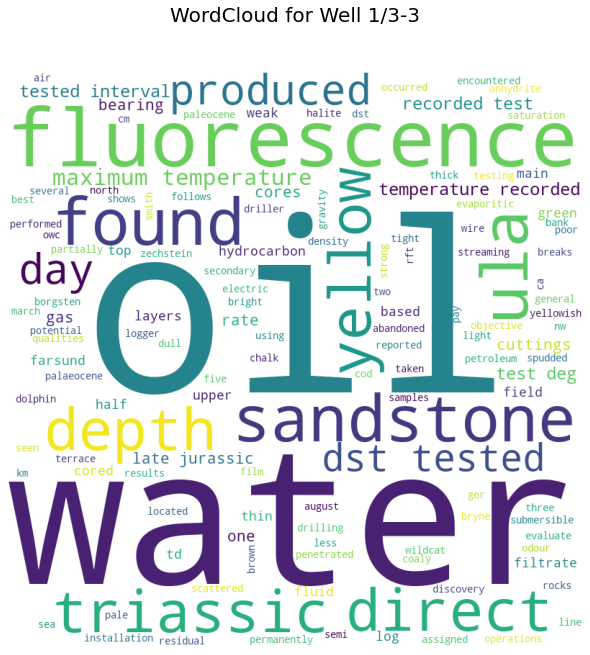

In [53]:
WordCloud_plot(wordcloud, wellname)

In [54]:
# %reset

---

## Processing all summaries
We are going to use 'bag_of_words_no_stop' which we created above. It's a list of list, where every element is a bag of word for each summary.

In [55]:
type(bag_of_words_no_stop)

list

In [56]:
# len(bag_of_words_no_stop) # --> this should still return the same length of our original 'df_all_summaries' dataframe :)

#### A few words about tokenization, lemmatization/stemming and POS

<b>Corpus: </b>collection of all your texts or documents (here our well report summaries)<br>

Note that we are going to use interchangeably 'token', 'word', and 'term'.<br>

<b>Tokenization: </b>splitting a phrase, sentence, paragraph, or an entire text document into smaller units, such as individual words or terms. Each of these smaller units are called tokens.<br>

<b>Lemmatization vs stemming: </b>Lemmatization is the process of converting a word to its base form. The difference between stemming and lemmatization is, lemmatization considers the context and converts the word to its meaningful base form, whereas stemming just removes the last few characters, often leading to incorrect meanings and spelling errors.<br>
For example, lemmatization would correctly identify the base form of ‘caring’ to ‘care’, whereas, stemming would cutoff the ‘ing’ part and convert it to car.<br>

‘Caring’ -> Lemmatization -> ‘Care’<br>
‘Caring’ -> Stemming -> ‘Car’<br>

Knowing this, I would say that Lemmatization is a more 'correct' way of treating text. Stemming seems to 'oversimplify'. OTOH, Stemming could be a way to process large amount of texts more quickly. Possibly one way to avoid word ambiguity with stemming would be to use bigrams/trigrams (association of two or three words together in order to give context). In this notebook we chose Lemmatization, since we are not using GPU (working with bigrams/trigrams is processor intensive).<br>

<b>Part Of Speach (POS): </b>also called grammatical tagging is the process of marking up a word in a text (corpus) as corresponding to a particular part of speech, based on both its definition and its context.<br>

<img src="../images/POS_online_example.jpg" width=700 >

#### A few words about spaCy
spaCy is a pretrained language model. In this notebook we are going to use language model 'en_core_web_sm-3.0.0'.<br>

<b>We asked GPT-3 those questions. Here are some short answers!</b><br>
Q: What is a pretrained language model?<br>
GPT-3: A pretrained language model is a language model that has been trained on a large amount of data.<br>
Q: What is a language model?<br>
GPT-3: A language model is a statistical model that estimates the probability of a word given a context.<br>
Q: In which context do you use a language model?<br>
GPT-3: A language model is used in the fields of machine translation, speech recognition, and information retrieval.<br>
(answers generated in GPT-3 Playground area on beta.open.ai)

#### Please check in the introduction at the top of this notebook how to install spaCy library

In [57]:
# path to our spaCy language model
path_spacy_model = '/anaconda3/envs/python37/lib/python3.7/site-packages/en_core_web_sm/en_core_web_sm-3.0.0'

# loading the model
nlp = spacy.load(path_spacy_model, disable=['parser', 'ner'])

In [58]:
type(nlp)

spacy.lang.en.English

#### Reducing the term count
We have already removed our stop words.<br>
The lemmatization will allow us to select a specific type of word, for instance 'NOUN'

In [59]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV', 'PROPN']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))    # remember: nlp is defined in our previous cell, it is the spaCey language model
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [60]:
bag_of_words_no_stop_lemma = lemmatization(bag_of_words_no_stop, allowed_postags=['NOUN'])

In [61]:
print(bag_of_words_no_stop_lemma[wi1])

['cod', 'terrace', 'north', 'sea', 'hydrocarbon', 'jurassic', 'triassic', 'sandstone', 'jurassic', 'ula', 'oil', 'bearing', 'ula', 'field', 'km', 'sandstone', 'oil', 'bearing', 'ula', 'field', 'operation', 'result', 'wildcat', 'installation', 'dolphin', 'depth', 'driller', 'depth', 'water', 'drilling', 'break', 'layer', 'sandstone', 'chalk', 'sandstone', 'layer', 'farsund', 'jurassic', 'ula', 'objective', 'oil', 'bearing', 'owc', 'half', 'quality', 'core', 'coaly', 'bryne', 'triassic', 'smith', 'bank', 'zechstein', 'rock', 'halite', 'hydrocarbon', 'saturation', 'log', 'paleocene', 'triassic', 'show', 'fluorescence', 'cutting', 'fluorescence', 'streaming', 'fluorescence', 'cutting', 'fluorescence', 'fluorescence', 'fluorescence', 'fluorescence', 'cutting', 'half', 'depth', 'log', 'depth', 'rft', 'wire', 'line', 'fluid', 'sample', 'gas', 'water', 'oil', 'film', 'water', 'water', 'petroleum', 'odour', 'fluid', 'march', 'oil', 'discovery', 'testing', 'dst', 'dst', 'interval', 'water', 'rat

In [62]:
len(bag_of_words_no_stop_lemma[wi1])

129

---

#### Let's try to build wordcloud on the lemmatized summary with only Nouns.

In [63]:
flat_list_to_string_lemma = ''
flat_list_to_string_lemma += " ".join(bag_of_words_no_stop_lemma[wi1])+" "

In [64]:
flat_list_to_string_lemma

'cod terrace north sea hydrocarbon jurassic triassic sandstone jurassic ula oil bearing ula field km sandstone oil bearing ula field operation result wildcat installation dolphin depth driller depth water drilling break layer sandstone chalk sandstone layer farsund jurassic ula objective oil bearing owc half quality core coaly bryne triassic smith bank zechstein rock halite hydrocarbon saturation log paleocene triassic show fluorescence cutting fluorescence streaming fluorescence cutting fluorescence fluorescence fluorescence fluorescence cutting half depth log depth rft wire line fluid sample gas water oil film water water petroleum odour fluid march oil discovery testing dst dst interval water rate day temperature test dst interval water rate day temperature test dst interval water rate day temperature test dst interval oil gas day oil density cm gas gravity air maximum temperature test '

In [65]:
# redefine the WordCloud for lemmatized summary
wordcloud = WordCloud(width = 800, height = 800, 
            background_color ='white', 
            stopwords = stop_words, 
            min_font_size = 10).generate(flat_list_to_string_lemma)

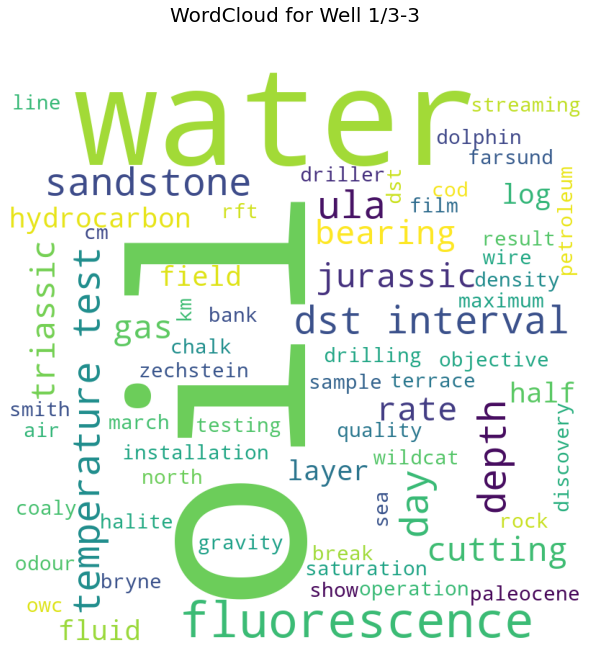

In [66]:
WordCloud_plot(wordcloud, wellname)

---

#### Inspect most frequest terms from our lemmatized bag of words

In [67]:
def detoken(texts):
    """detokenizer"""
    texts_out = []
    for sent in texts:
        texts_out.append(" ".join(s for s in sent))
    return texts_out

bag_of_words_no_stop_lemma_test = detoken(bag_of_words_no_stop_lemma)    # reassembling lists of tokens into continuous lists of strings

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(bag_of_words_no_stop_lemma_test)
freq = np.ravel(X.sum(axis=0)) 

vocab = [v[0] for v in sorted(vectorizer.vocabulary_.items(), key=operator.itemgetter(1))]
fdist = dict(zip(vocab, freq))

# Save all terms as CSV file to inspect all

with open('term_dict.csv', 'w', encoding='utf-8') as f:
    for key in fdist.keys():
        f.write("%s,%s\n"%(key,fdist[key]))

In [68]:
# bag_of_words_no_stop_lemma_test[0:3]

#### Create a document-term-matrix (DTM) --> this is going to be used in the topic modelling function below

In [69]:
# Create Dictionary
id2word = Dictionary(bag_of_words_no_stop_lemma)
print("Length of initial dictionary is: ", (len(id2word)))

### id2word.filter_extremes(no_below=5, no_above=0.1)  # 'no_above=1': tokens appearing in all documents (100% of the corpus) will not be removed
id2word.filter_extremes(no_below=5, no_above=0.5)      # 'no_below=5': tokens appearing less that 5 times in all documents will be removed
                            
print("Length of reduced dictionary is: ", (len(id2word)))

# Create Corpus
texts = bag_of_words_no_stop_lemma

# Term Document Frequency
corpus1 = [id2word.doc2bow(text) for text in texts]

# View
print(corpus1[:1])
print(id2word)

Length of initial dictionary is:  3843
Length of reduced dictionary is:  1436
[[(0, 1), (1, 1), (2, 1), (3, 2), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 2), (18, 1), (19, 1), (20, 3), (21, 1), (22, 2), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 2), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 2), (44, 1), (45, 1), (46, 2), (47, 1), (48, 1), (49, 2), (50, 1), (51, 1), (52, 2), (53, 1)]]
Dictionary(1436 unique tokens: ['analysis', 'api', 'attempt', 'barrier', 'bearing']...)


<b>Note about method 'filter_extreme': </b>'no_above' parametre is the way to remove tokens which are too ubiquitous: by appearing in all (or almost all) well summaries, these tokens do not bring any particular information (no_above=1). 'No_above=0.5' means that tokens which appear in more that 50% of the summaries will be dropped.<br>
Increasing the value for 'no_above' also increases the <b>perplexity</b> value: the model will have more difficulty to generate the different topics (topics will overlap significantly).

In [70]:
# Convert corpus to a numpy matrix
numpy_matrix = gensim.matutils.corpus2dense(corpus1, num_terms=len(id2word)) # adjust based on length of dictionary

# Create a filtered matrix that removes docs with less than 5 terms
n_matrix2 = numpy_matrix[:, (numpy_matrix != 0).sum(axis=0) > 4]

# Convert matrix back to a corpus
corpus = gensim.matutils.Dense2Corpus(n_matrix2)

# Confirm change has been made
print(len(corpus1)) # original corpus
print(len(corpus)) # new corpus

1825
1823


---

## Topic modeling
<b>What is Topic modeling?</b><br>
GPT-3: Uncovering the hidden or latent topics across a set of documents.<br>
A given number of themes (or topics) will be generated by grouping words which have an apparent connected meaning.<br>
Topic modeling has similarities to clustering. But topic models can also been used for understanding, exploring, and visualizing a collection of texts.<br>

#### We are going to calculate coherence values for various numbers of topics. In this way we can select which number of topics seems the most suitable.
<b>Topic Coherence</b> is a score in a single topic which measures the degree of semantic similarity between high scoring words in the topic (or: how a given topic is semantically coherent).

In [71]:
# Function to Calculate topic coherence for topic models

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    alpha = [0.1, 1, 10]
    random_seed = [32, 64]
    coherence_values = []
    model_list = []
    output_list = []
    for num_topics in range(start, limit, step):
        for a in alpha:
            for r in random_seed:
                model = gensim.models.LdaMulticore(corpus=corpus, id2word=id2word, num_topics=num_topics, random_state=r, alpha=a, workers=3)
                model_list.append(model)
                coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
                coherence_values.append(coherencemodel.get_coherence())
                model_output ={'alpha': a, 'random_seed': r, 'coherence': coherencemodel.get_coherence(), 'num_topics': num_topics}
                output_list.append(model_output)
              
    return model_list, coherence_values, output_list

In [72]:
model_list, coherence_values, output_list = compute_coherence_values(dictionary=id2word,
                                                                     corpus=corpus, texts=texts, start=4, limit=18, step=2)

#### Inspect the models - here we see that the models tries different numbers of topics - we'll try the number of topics with highest coherence

In [73]:
output_list_descending = sorted(output_list, key=lambda d: d['coherence'], reverse=True)
pprint(output_list_descending)

[{'alpha': 1,
  'coherence': 0.3181318719926228,
  'num_topics': 6,
  'random_seed': 32},
 {'alpha': 10,
  'coherence': 0.31778878753654727,
  'num_topics': 6,
  'random_seed': 32},
 {'alpha': 10,
  'coherence': 0.3171311610229798,
  'num_topics': 6,
  'random_seed': 64},
 {'alpha': 10,
  'coherence': 0.316125536013382,
  'num_topics': 10,
  'random_seed': 32},
 {'alpha': 10,
  'coherence': 0.31600355344423214,
  'num_topics': 8,
  'random_seed': 32},
 {'alpha': 1,
  'coherence': 0.3145534842188197,
  'num_topics': 8,
  'random_seed': 32},
 {'alpha': 10,
  'coherence': 0.3130388448496137,
  'num_topics': 12,
  'random_seed': 32},
 {'alpha': 10,
  'coherence': 0.3128849587338226,
  'num_topics': 16,
  'random_seed': 32},
 {'alpha': 10,
  'coherence': 0.31251529218461854,
  'num_topics': 8,
  'random_seed': 64},
 {'alpha': 0.1,
  'coherence': 0.31109926812666444,
  'num_topics': 14,
  'random_seed': 64},
 {'alpha': 10,
  'coherence': 0.31083400247315957,
  'num_topics': 14,
  'random_see

#### Build LDA model - here we chose to generate 6 topics
GPT-3: LDA stands for Latent Dirichlet Allocation, a topic model for discovering the topics in a collection of documents.<br>
GPT-3: The main characteristics of LDA are that it does not assume a fixed number of topics and it works well with very large collections of documents.

In [74]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=6, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

#### Print the most frequent words in the 6 topics (the attribution of the group number is random)

In [75]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.102*"dst" + 0.081*"day" + 0.064*"temperature" + 0.049*"gravity" + '
  '0.034*"flow" + 0.030*"air" + 0.029*"rate" + 0.029*"cm" + 0.027*"density" + '
  '0.025*"deg"'),
 (1,
  '0.040*"contact" + 0.036*"brent" + 0.031*"pressure" + 0.029*"statfjord" + '
  '0.028*"appraisal" + 0.024*"column" + 0.020*"field" + 0.019*"sidetrack" + '
  '0.018*"north" + 0.016*"owc"'),
 (2,
  '0.034*"sandne" + 0.031*"section" + 0.026*"shale" + 0.024*"source" + '
  '0.022*"bryne" + 0.018*"drilling" + 0.017*"rock" + 0.016*"seawater" + '
  '0.016*"salt" + 0.014*"coal"'),
 (3,
  '0.080*"sand" + 0.022*"log" + 0.020*"porosity" + 0.019*"drilling" + '
  '0.016*"bearing" + 0.016*"area" + 0.015*"rft" + 0.014*"block" + '
  '0.014*"polymer" + 0.014*"depth"'),
 (4,
  '0.051*"garn" + 0.045*"structure" + 0.028*"tilje" + 0.027*"lange" + '
  '0.026*"yme" + 0.025*"sidetrack" + 0.025*"fangst" + 0.020*"pressure" + '
  '0.017*"contact" + 0.017*"part"'),
 (5,
  '0.028*"prospect" + 0.020*"rock" + 0.020*"stø" + 0.020*"section"

#### Remember Perplexity that we saw about 'filter_extremes()' method? We are going to calculate it below.
GPT-3: Perplexity is a measure of how well a topic model represents a collection of documents.<br>
It captures how surprised a model is of new data it has not seen before


In [76]:
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.


Perplexity:  -6.184317378366391


#### Compute Coherence Score
GPT-3: A coherency score of 1 indicates that the documents are completely coherent, meaning they are about the same topic. A coherency score of 0 indicates that the documents are completely incoherent, meaning they are about completely different topics.

In [77]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=bag_of_words_no_stop_lemma, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.4359404194774355


#### Visualize the topics - note: here topics are numbered from largest group to smallest group (% of tokens)

In [78]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.131410 -0.049840       1        1  23.736820
5     -0.178696  0.013489       2        1  22.587793
1      0.100206  0.170152       3        1  19.853729
2     -0.227584 -0.094563       4        1  16.126154
0      0.287965 -0.266120       5        1  10.572724
4      0.149518  0.226881       6        1   7.122780, topic_info=    Category         Freq         Term        Total  loglift  logprob
44   Default  2178.000000         sand  2178.000000  30.0000  30.0000
95   Default  1230.000000          dst  1230.000000  29.0000  29.0000
14   Default  1151.000000          day  1151.000000  28.0000  28.0000
51   Default   771.000000  temperature   771.000000  27.0000  27.0000
23   Default   595.000000      gravity   595.000000  26.0000  26.0000
..       ...          ...          ...          ...      ...      ...
139   Topic6   117.474022    appraisal   971.199585   0.5296  -4.2394
147   Topic6    83.171585  development   312.507141   1.3182  -4.5847
170   Topic6    77.825035         kick   254.174957   1.4583  -4.6512
63    Topic6    89.595970         east   584.168030   0.7670  -4.5103
287   Topic6    71.509453          fmt   363.183655   1.0168  -4.7358

[382 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
54        1  0.875679  accumulation
54        3  0.012600  accumulation
54        4  0.012600  accumulation
54        5  0.094498  accumulation
257       1  0.472052           age
...     ...       ...           ...
53        4  0.107999          wire
53        5  0.009818          wire
53        6  0.040909          wire
574       6  0.994011           yme
137       4  0.993244     zechstein

[598 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 6, 2, 3, 1, 5])

<b>About lambda parametre:</b><br>

 - Values of lambda that are very close to <b>zero</b> will show terms that are <b>more specific for a chosen topic</b>. Meaning that you will see terms that are "important" for that specific topic but not necessarily "important" for the whole corpus.

 - Values of lambda that are very close to one will show those terms that have the highest ratio between frequency of the terms for that specific topic and the overall frequency of the terms from the corpus.


lambda = 0: very specific words (words which are very specific to a given topic. In some cases the topic will contain exclusively that word).<br>
lambda = 1: generic words (words which appear in a given topic but are also common in the rest of the corpus.<br>

<b>Check out <a href="https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf"> article page 64 and 68!</a></b> for further explanations about lambda.<br>

<b>What are PC1 and PC2?</b><br>
PCA (Principal Component Analysis) assumes that the directions with the largest variances are the most 'important' (i.e, the most principal). The PC1 axis is the first principal direction along which the samples show the largest variation. The PC2 axis is the second most important direction and it is orthogonal to the PC1 axis.<br>
GPT-3: Principal Component Analysis is a statistical method for reducing the dimensionality of data.

---

---

In [79]:
# Reading term_dict csv file into a pandas and sort the df by frequencies 
# to see which words are very frequent (ubiquitous).
df_term_dict = pd.read_csv('term_dict.csv', names=['token', 'frequency'])
df_term_dict.sort_values('frequency', ascending= False, inplace=True)

In [80]:
df_term_dict.shape

(3841, 2)

In [81]:
df_term_dict.head()

token  frequency
2371        oil       7623
1340        gas       5759
3428       test       3988
3741      water       3981
2950  sandstone       3546

---

In [82]:
# a quick example of what spaCy language model can return as information :)
# from spacy import displacy

In [83]:
### Unfortunately, the graphic rendering is not working fully (no error message):
### vectors showing relations between tokens do not show.
# doc = nlp("My name is Anne.")
# displacy.render(doc, style='ent', jupyter=True)
# displacy.render(doc, jupyter=True)